# 프로젝트 : CIFAR-10 이미지 생성하기

## 루브릭 관련 고려한 점

**1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.**

- 오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.

**2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.**

- gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.

**3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.**

- 제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.


### [학습 과정]
1. 작업환경 구성하기
2. 데이터셋 구성하기
3. 생성자 모델 구현하기
4. 판별자 모델 구현하기
5. 손실함수와 최적화 함수 구현하기
6. 훈련과정 상세 기능 구현하기
7. 학습 과정 진행하기
8. (optional) GAN 훈련 과정 개선하기

### [결과 및 회고]


---

## STEP 1. 데이터셋 구성하기

- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)



tensorflow 2.6.0


In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 51s 0us/step


(50000, 32, 32, 3)

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


- 이미지데이터여서 0~255 값으로 이뤄져있습니다.
- [-1, 1]로 정규화로 하기위해서 255/2 값인 127.5를 뺀 값을 127.5로 나눠줍니다.

In [4]:
train_x.astype('float32')
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

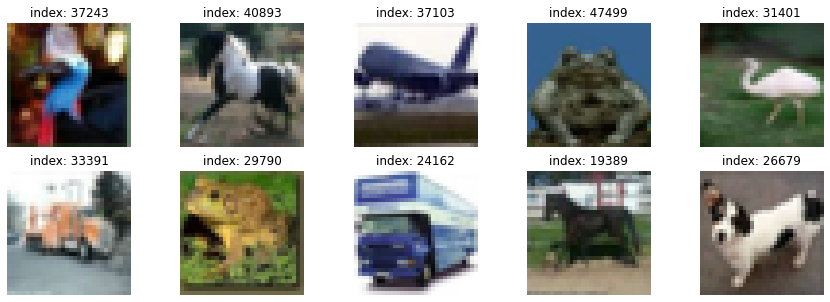

In [6]:
plt.figure(figsize=(15, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index] + 1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

- BUFFER_SIZE은 전체 데이터를 섞기 위해 50,000으로 설정합니다. 
- shuffle() 함수가 데이터셋을 잘 섞어서 모델에 넣어줄 것입니다.


- `BATCH_SIZE`는 모델이 한 번에 학습할 데이터의 양입니다.
- 미니배치 학습을 사용하기 위해 적절한 사이즈로 잘라서 데이터셋을 구성합니다.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

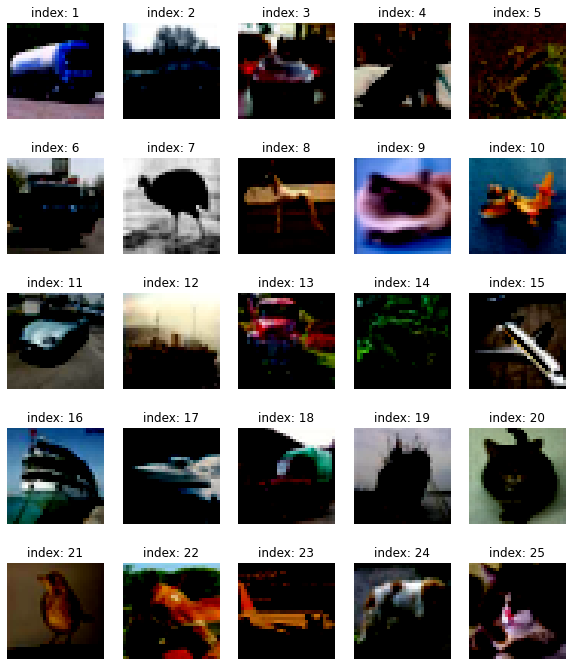

In [7]:
plt.figure(figsize=(10, 12))

for i in range(1,26):
    idx = np.random.randint(0, len(train_x)-1)
    plt.subplot(5,5, i)
    plt.imshow(train_x[idx].reshape(32, 32,3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>

## STEP 2. 생성자 모델 구현하기

- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

In [11]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

![image](https://user-images.githubusercontent.com/68802402/131218436-c3923cf2-47a8-4183-bd31-b673c7f79000.png)

Transpose Convolution은 위 그림과 같이 작동하여 이미지의 size를 증가시키는 결과를 가져온다


In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [13]:
# 노이즈를 생성합니다.
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

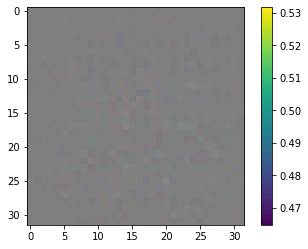

In [14]:
# 생성 노이즈 이미지 확인해보기
plt.imshow((generated_image[0]+ 1.0) / 2.0)
plt.colorbar()
plt.show()

## STEP 3. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다.
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [17]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0017892]], dtype=float32)>

## STEP 4. 손실함수와 최적화 함수 구현하기

- 생성자와 판별자의 r각각의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

- 생성자, 판별자의 손실함수 및 accuracy 지표 구현한다.
- GAN은 손실함수로 Crossentropy를 사용한다.
- def generator_loss(fake_output) : Crossentropy를 사용해 생성한 이미지가 판별자를 얼마나 잘 속였는지 파악. -> 작을 수록 좋다.
- def discriminator_loss(real_output, fake_output) : 판별자가 진실과 거짓을 얼마나 잘 판별했는지 두개의 Crossentropy의 합으로 가늠. -> 작을 수록 좋다.
- def discriminator_accuracy(real_output, fake_output) : 생성자가 이미지를 잘 만들어내면 판별자는 이미지가 진실인지 거짓인지를 판단하기 어려워 확률에 의존하게 된다. 즉, accuracy는 0.5에 수렴할 수록 생성자가 제대로 학습한 것이다.

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [23]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## STEP 5. 훈련과정 상세 기능 구현하기

- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

In [24]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [38]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    np_predictions = predictions.numpy()
    np_predictions = (np_predictions * 127.5) + 127.5 # 정규화 했던 것을 되돌리기
    np_predictions = np_predictions.astype(int)   
    
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(np_predictions[i])
        plt.axis('off')
        

    plt.savefig('C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))

    plt.show()

In [39]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10    # matlab 차트의 기본 크기를 15,10으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(epoch))
    plt.show()

In [40]:
checkpoint_dir = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## STEP 6. 학습 과정 진행하기

- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다.

In [41]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [42]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

- checkpoint를 통해 모델이 로드되었으면 아래 코드를 실행할 경우 로드된 모델의 파라미터 상태에서 훈련을 재개할 수도 있습니다.

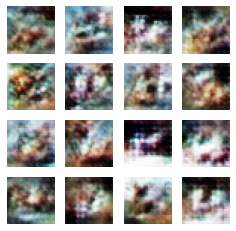

Time for training : 407 sec


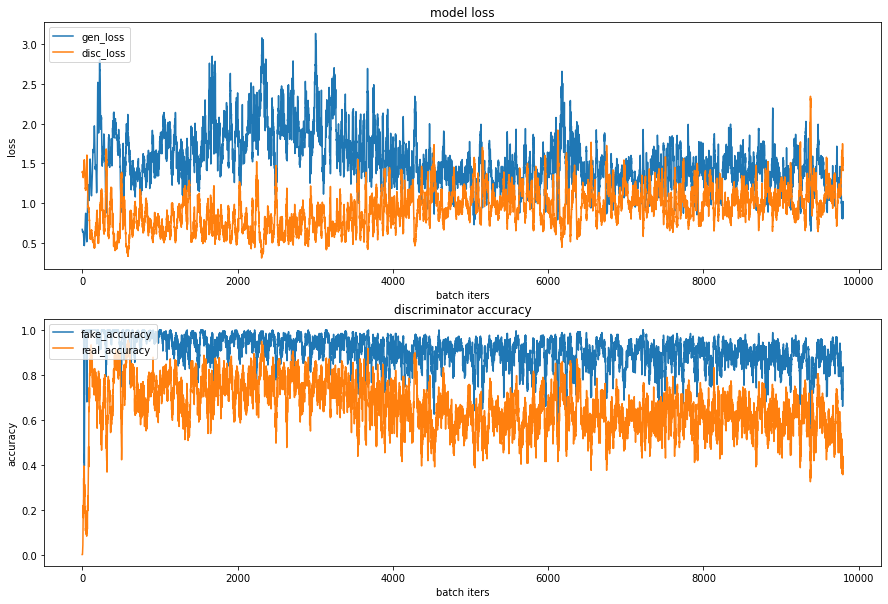

Wall time: 6min 48s


In [43]:
%%time
train(train_dataset, EPOCHS, save_every)

In [54]:
anim_file = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/cifar10_dcgan_01.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/generated_samples/sample*.png'
    .format())
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


![cifar10_dcgan_01](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_01.gif?raw=true)


- 이게 잘 구분이 되는 건가 싶습니다.
- 노이즈에서 덩어리 형태로 변했지만 디테일한 분간은 어렵습니다.
- 에폭별로 발전이 있다고 생각하고 에폭을 증가해서 훈련을 시켜봐야겠습니다.

## STEP 7. (optional) GAN 훈련 과정 개선하기

- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.


- 학습 과정 중 학습 epoch를 추가 진행해야 하거나, 학습한 모델을 활용하여 이미지를 생성할 필요가 생깁니다. 
- 그럴 때마다 모델 학습을 처음부터 다시 진행한다면 시간 낭비가 될 것입니다.
- 우리는 위에서 checkpoint 모듈을 이용해 모델을 저장해 둔 바 있습니다. 
- 이를 이용해 학습해 둔 모델을 로드하면 모델 재학습이 필요 없이 이런 작업을 진행할 수 있습니다.

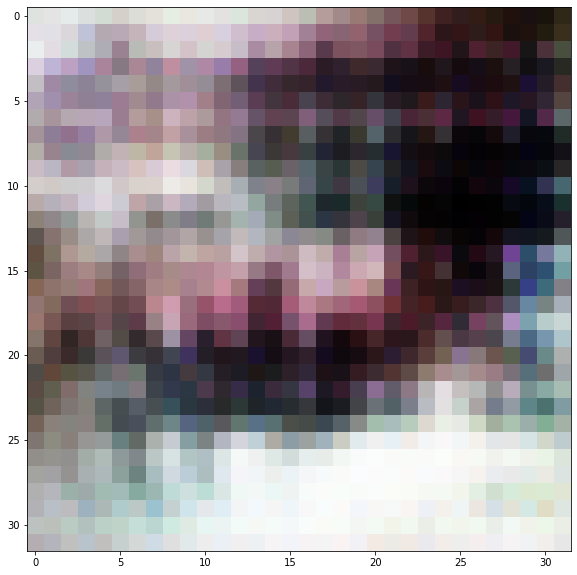

In [55]:
checkpoint_dir = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

- CIFAR-10의 명확한 이미지로 보기 힘듭니다.
- 에폭을 증가시켜 확인해봅니다.

In [56]:
save_every = 5
EPOCHS = 100

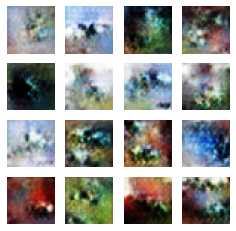

Time for training : 860 sec


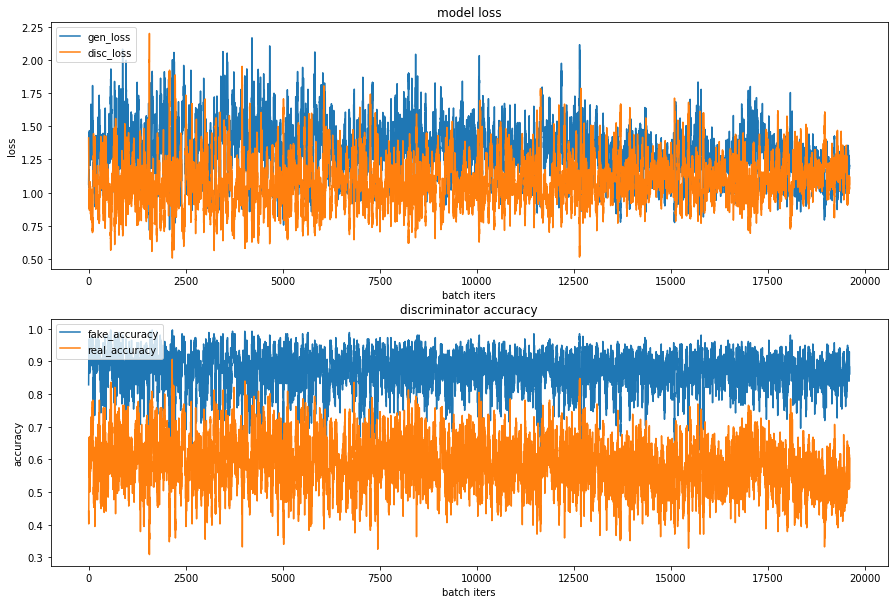

Wall time: 14min 21s


In [57]:
%%time
train(train_dataset, EPOCHS, save_every)

In [60]:
anim_file = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/cifar10_dcgan_02.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/generated_samples/sample*.png'
    .format())
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

- epoch=100
![cifar10_dcgan_02](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_02.gif?raw=true)


- 이전보다 더 디테일 해진 것 같으나 아직 분간되지 않는 것 같습니다.

---

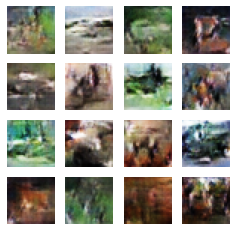

Epoch 218 | iter 101
Time for epoch 218 : 4 sec


In [ ]:
checkpoint_dir = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 500

train(train_dataset, EPOCHS, save_every)

In [37]:
anim_file = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/cifar10_dcgan_03.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/generated_samples/sample*.png'
    .format())
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif': No such file or directory


![cifar10_dcgan_03](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_03.gif?raw=true)

- 에폭이 문제가 아니라 다른 시도를 해봐야 할 것 같습니다.

---

- 성능향상을 위해서 adam optimizer의 learning rate를 5e-4로 설정하면 더 효과적이란 글을 보고 시도했습니다.
- def generate_and_save_images() 에서 정규화 해준 부분을 되돌려서 초록색으로 표시되던 이미지가 원래 색상으로 확인이 가능해졌습니다.

In [38]:
generator_optimizer = tf.keras.optimizers.Adam(5e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-4)

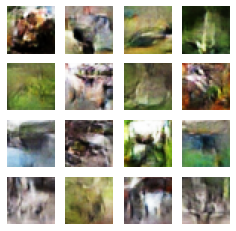

Time for training : 772 sec


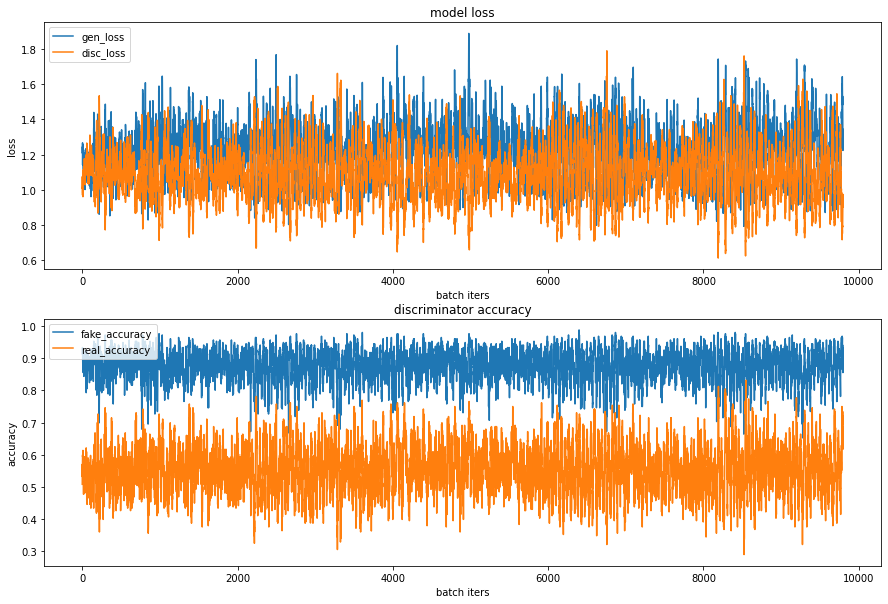

In [39]:
checkpoint_dir = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 50

train(train_dataset, EPOCHS, save_every)

In [40]:
anim_file = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/cifar10_dcgan_04.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/generated_samples/sample*.png'
    .format())
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif': No such file or directory


![cifar10_dcgan_04](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_04.gif?raw=true)

- 학습률 조정을 하면 좋다고 하는데 확실히 더 나은 결과가 나온 것 같습니다.

---

- 배치사이즈 수정 256 -> 64

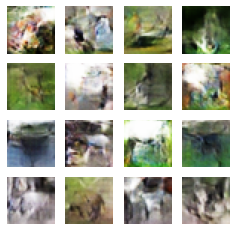

Time for training : 1572 sec


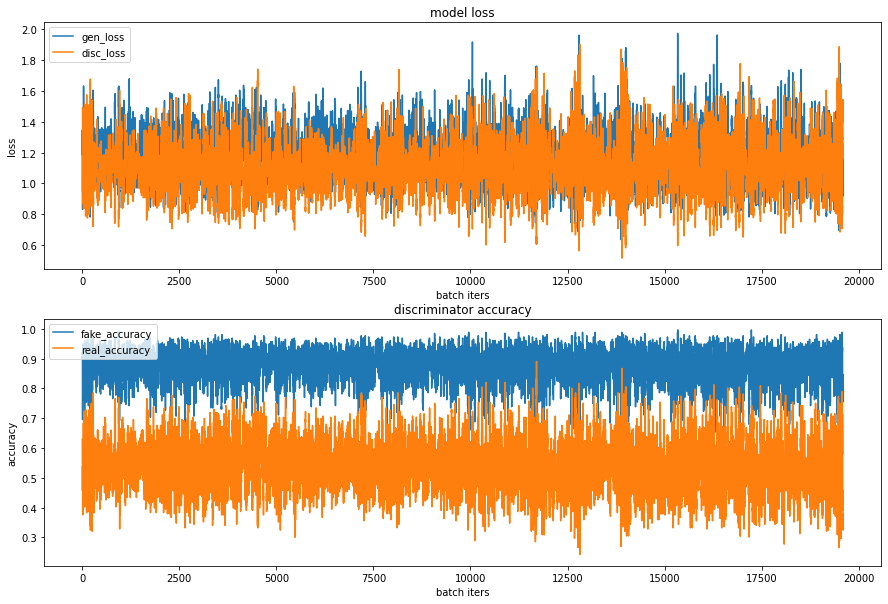

In [41]:
checkpoint_dir = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 100

train(train_dataset, EPOCHS, save_every)

In [42]:
anim_file = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/cifar10_dcgan_05.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/generated_samples/sample*.png'
    .format())
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif': No such file or directory


![cifar10_dcgan_05](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_05.gif?raw=true)

- 배치 안고친게 더 나을듯 합니다.
- 느낀 결론은 에폭을 많이 돌리는게 맞는것 같다.
- 다시 한번 500 에폭을 돌립니다.

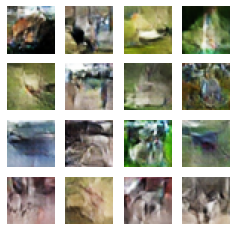

Time for training : 8905 sec


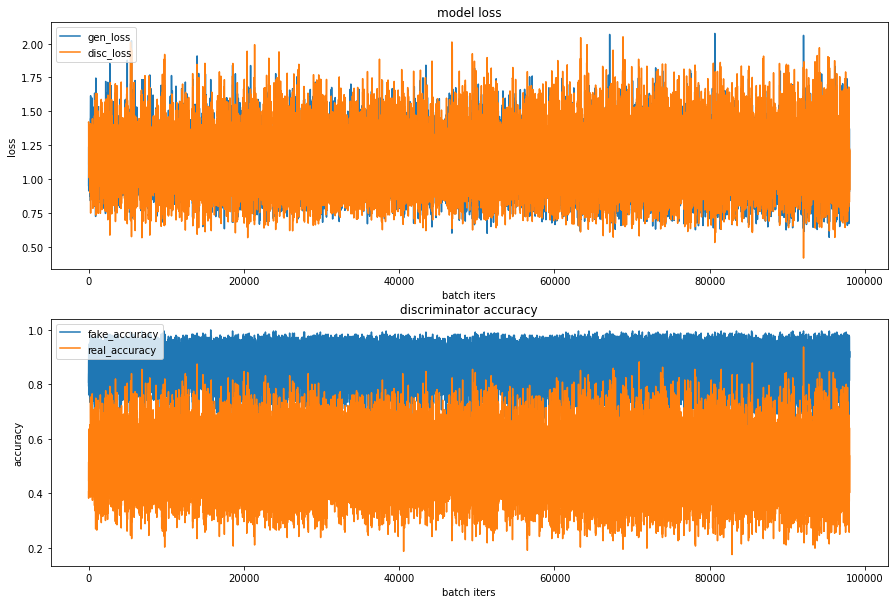

In [43]:
checkpoint_dir = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

save_every = 5
EPOCHS = 1000

train(train_dataset, EPOCHS, save_every)

In [44]:
anim_file = 'C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/cifar10_dcgan_06.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('C:/Users/Noah/aiffel/E10 MakeNewFashionGAN/dcgan_newimage/cifar10/generated_samples/sample*.png'
    .format())
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif': No such file or directory


![cifar10_dcgan_06](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_06.gif?raw=true)


- 맨 처음 시도와 비교하면 형태가 있긴하나 원복 이미지보다는 나아진 것같습니다.
- 하이퍼파라미터 변경 외에 다른 시도가 필요할 것으로 보입니다.

### 이후 ,  테스트까지하면서, 마지막으로 모델들을 수정하여 진행하였으나, 저장이 제대로 되지않아, 모든것을 다 돌리기엔 시간이 부족하여, 아래와 같이 남겼습니다. 제출후에 새로 모델을 돌려 업로드 할예정입니다. https://github.com/4thgen/DCGAN-CIFAR10 모델 참고

기본적인 모델 강화

- Generator 강화
- Generator + Discriminator 강화
- Generator + Discriminator 파라미터 수 대폭 증가
- 하이퍼 파라미터 수정
- Learing Rate
- beta_1 of Adam optimizer

### Generator 강화

Generator 모델에 레이어를 하나 더 추가해주었다.

**Generator**
```python
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Activation('tanh'))

    return model
```

### Generator + Discriminator 성능강화

이번에는 Generator와 Discriminator 둘 다 레이어를 추가해보았다.

**Generator**
```python
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Activation('tanh'))

    return model
```

**Discriminator**
```python
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model
```

### Generator + Discriminator 파라미터 수 대폭 늘리기

- **Generator**
```python
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 1024)))

    # 레이어 추가
    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.Activation('tanh'))

    return model
```
```
Total params: 18,920,320
Trainable params: 18,885,760
Non-trainable params: 34,560
```


**Discriminator**
```python
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model
```
```
Total params: 8,850,177
Trainable params: 8,846,337
Non-trainable params: 3,840
```

### 최종 모델
**Generator**
```python
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.Activation('tanh'))

    return model

```
```
Total params: 5,159,360
Trainable params: 5,142,080
Non-trainable params: 17,280
```

---

# 성능 향상 시도

| 시도 | 모델 구성 | 변경사항 | Epochs | 결과 |
| :---: | :---: | :---: | :---: | :---: |
| 첫번째 | - | 기본모델 | 50 |![cifar10_dcgan_01](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_01.gif?raw=true) |
| 두번째 | - | Epochs 증가 50→100 으로 | 100 |![cifar10_dcgan_02](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_02.gif?raw=true) |
| 세번째 | - | Epochs 증가 100 → 500으로 | 500 |![cifar10_dcgan_03](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_03.gif?raw=true) |
| 네번째 | - | learning rate를 2e-4로 설정하면 더 효과적이란 글을 보고 시도햇지만, 5e-4로 결정 | 50 |![cifar10_dcgan_04](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_04.gif?raw=true) |
| 다섯번째 | - | 배치사이즈 256 ~ 64까지 테스트 후, 64로 수정 | 100 |![cifar10_dcgan_05](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_05.gif?raw=true) |
| 여섯번째 | - | 배치사이즈 원복 시킨 후 , 에폭만 증가.  | 500 |![cifar10_dcgan_06](https://github.com/Noah-Junseo/AIFFEL_EXPLORATION_US/blob/main/%5BE-10%5D%20MakeNewFashionGAN/cifar10_dcgan_06.gif?raw=true) |




#### latent space의 정의 / 높아질수록 학습 성능 떨어짐

**Thus, as dimensionality is reduced, the ‘extraneous’ information which is distinct to each image (i.e. chair color) is ‘removed’ from our latent space representation, since only the most important features of each image are stored in the latent space representations.**<br/><br/>
필터가 3개로 늘어나서 n_dim을 늘려서 학습시킨 나의 불찰이었다. 차원을 늘려서 쓸데없는 feature까지 모델이 신경써서 학습 진행이 제대로 진행되지 않았던 것. <br/>
**latent space의 차원을 낮춰서 다시 진행하자**


# 성능 향상을 위한 방법 정리
1. **normalize the images between -1 and 1**
2. Use **Adam Optimization**
3. **Avoid** Sparse Gradients: **ReLU, MaxPool**
4. **Use DCGAN** when you can. It works!<br/>**if you cant use** DCGANs and no model is stable, **use a hybrid model : KL + GAN or VAE + GAN**
5. In GAN papers, the loss function to optimize G is min (log 1-D), but in practice folks practically **use max log D**
6. **Track failures early**
    - D loss goes to 0: failure mode
    - check norms of gradients: if they are over 100 things are screwing up
    - when things are working, D loss has low variance and goes down over time vs having huge variance and spiking
    - if loss of generator steadily decreases, then it's fooling D with garbage (says martin)
    
    
7. The model for the **discriminator is usually more complex than the generator** (more filters and more layers) and a good discriminator gives quality information

8. While training your **GAN use a batch size smaller than or equal to 64**. Using a bigger batch size might hurt the performance


[Tips On Training Your GANs Faster and Achieve Better Results](https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5)

[Ways to improve GAN performance](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)

- 처음에 출력이 초록색으로 나오는 이유를 몰라서 한참 헤맸습니다. 출력부분 수정하는 방법은 generate_and_save_images() 내용을 수정했습니다.
- 앞에 -1~1으로 바꿨는데 그 부분을 다시 복원시켜서 출력하는 작업을 했다. 또한 모델 층 쌓다가 모양이 안맞아서 에러가 났는데 에폭을 많이 돌리고 싶어서 다른 거 했는데 위에서 부터 차분히 고쳤으면 했다. 시파텐에 가까운 형상이였으면 좋겠는데 약간 아쉽다.
- 초록색으로 출력되서 의문이였는데 RGB 컬러를 나오게 해줬습니다.gan 모델 결과값에 대한 해석을 공부하게 되었다.
- 루브릭을 보고 fake accuracy가 추세적으로 0.5를 향해가야하는 이유에 대해 궁금했는데 물어보자마자 
  @원진님과 @지영님께서 알려주셨습니다.
- 배운게 많았습니다 항상 감사합니다.

GAN의 성능을 올리는 방법을 다룬 블로그 글이나 논문은 수없이 많이 인터넷에 있다. 하지만 그러한 글들의 Learnin rate, 모델을 따라한다고 해서 내 모델에서 잘 돌아가는 것은 아님
에폭을 많이 가져갈 수록 "사람 눈"에 만족스러운 그림이 나오는 것 같긴 하지만 D,G의 accuracy나 loss는 사람과 많이 다른 듯 하다.
StyleGAN에도 관심이 생겨 공부해보고 싶다.

이걸 하면서 느낀점은.. 하루 빨리 개인환경을 구축해서 해야겠다라는 생각이 들었다..

인간적으로 학습하는데 너무 느린것 같다.. 내가 사용하는 데스크탑환경이 훨씬 빠를 꺼란 생각이 든다..